In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("ipl.csv", low_memory=False)
print(df.shape)
df.head()

(278205, 64)


,Unnamed: 0,match_id,date,match_type,event_name,innings,batting_team,bowling_team,over,ball,...,team_runs,team_balls,team_wicket,new_batter,batter_runs,batter_balls,bowler_wicket,batting_partners,next_batter,striker_out
0,131970,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,...,1,1,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
1,131971,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,...,1,2,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
2,131972,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,...,2,2,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
3,131973,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,...,2,3,0,NaN,0,2,0,"('BB McCullum', 'SC Ganguly')",NaN,False
4,131974,335982,2008-04-18,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,...,2,4,0,NaN,0,3,0,"('BB McCullum', 'SC Ganguly')",NaN,False


In [7]:
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278205 entries, 0 to 278204
Data columns (total 64 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         278205 non-null  int64  
 1   match_id           278205 non-null  int64  
 2   date               278205 non-null  object 
 3   match_type         278205 non-null  object 
 4   event_name         278205 non-null  object 
 5   innings            278205 non-null  int64  
 6   batting_team       278205 non-null  object 
 7   bowling_team       278205 non-null  object 
 8   over               278205 non-null  int64  
 9   ball               278205 non-null  int64  
 10  ball_no            278205 non-null  float64
 11  batter             278205 non-null  object 
 12  bat_pos            278205 non-null  int64  
 13  runs_batter        278205 non-null  int64  
 14  balls_faced        278205 non-null  int64  
 15  bowler             278205 non-null  object 
 16  va

In [9]:
# Strip whitespace
df["batting_team"] = df["batting_team"].astype(str).str.strip()
df["bowling_team"] = df["bowling_team"].astype(str).str.strip()

# Convert numeric columns safely
numeric_cols = [
    "over", "ball", "batsman_runs", "extras",
    "total_runs", "is_wicket"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.fillna(0, inplace=True)

In [17]:
df.columns.tolist()

['Unnamed: 0',
 'match_id',
 'date',
 'match_type',
 'event_name',
 'innings',
 'batting_team',
 'bowling_team',
 'over',
 'ball',
 'ball_no',
 'batter',
 'bat_pos',
 'runs_batter',
 'balls_faced',
 'bowler',
 'valid_ball',
 'runs_extras',
 'runs_total',
 'runs_bowler',
 'runs_not_boundary',
 'extra_type',
 'non_striker',
 'non_striker_pos',
 'wicket_kind',
 'player_out',
 'fielders',
 'runs_target',
 'review_batter',
 'team_reviewed',
 'review_decision',
 'umpire',
 'umpires_call',
 'player_of_match',
 'match_won_by',
 'win_outcome',
 'toss_winner',
 'toss_decision',
 'venue',
 'city',
 'day',
 'month',
 'year',
 'season',
 'gender',
 'team_type',
 'superover_winner',
 'result_type',
 'method',
 'balls_per_over',
 'overs',
 'event_match_no',
 'stage',
 'match_number',
 'team_runs',
 'team_balls',
 'team_wicket',
 'new_batter',
 'batter_runs',
 'batter_balls',
 'bowler_wicket',
 'batting_partners',
 'next_batter',
 'striker_out']

In [19]:
# Total runs per ball (already present)
df["ball_runs"] = pd.to_numeric(df["runs_total"], errors="coerce")
df["ball_runs"].fillna(0, inplace=True)

In [21]:
df["is_wicket"] = df["player_out"].notna().astype(int)

In [23]:
df.rename(columns={"innings": "inning"}, inplace=True)

In [25]:
df["overs_completed"] = df["over"] + (df["ball"] / df["balls_per_over"])

In [27]:
df["cum_runs"] = df.groupby(
    ["match_id", "inning"]
)["ball_runs"].cumsum()

df["cum_wickets"] = df.groupby(
    ["match_id", "inning"]
)["is_wicket"].cumsum()

In [29]:
df["current_run_rate"] = df["cum_runs"] / df["overs_completed"]

In [31]:
df["runs_remaining"] = df["runs_target"] - df["cum_runs"]
df["balls_remaining"] = (df["overs"] * df["balls_per_over"]) - (
    df["over"] * df["balls_per_over"] + df["ball"]
)

df["required_run_rate"] = (
    df["runs_remaining"] / df["balls_remaining"]
) * df["balls_per_over"]

In [33]:
def match_phase(over):
    if over <= 5:
        return "Powerplay"
    elif over <= 14:
        return "Middle"
    else:
        return "Death"

df["phase"] = df["over"].apply(match_phase)

In [35]:
df["win"] = (df["batting_team"] == df["match_won_by"]).astype(int)

In [37]:
over_df = df.groupby(
    ["match_id", "inning", "batting_team", "over"]
).agg({
    "cum_runs": "last",
    "cum_wickets": "last",
    "current_run_rate": "last",
    "required_run_rate": "last",
    "overs_completed": "last",
    "win": "last"
}).reset_index()

In [39]:
features = [
    "cum_runs",
    "cum_wickets",
    "current_run_rate",
    "required_run_rate",
    "overs_completed"
]

X = over_df[features].fillna(0)
y = over_df["win"]

In [45]:
X = X.replace([np.inf, -np.inf], np.nan)

In [47]:
X = X.fillna(0)

In [49]:
np.isfinite(X).all()

cum_runs             True
cum_wickets          True
current_run_rate     True
required_run_rate    True
overs_completed      True
dtype: bool

In [51]:
X.describe()

,cum_runs,cum_wickets,current_run_rate,required_run_rate,overs_completed
count,44987.000000,44987.000000,44987.000000,44987.000000,44987.000000
mean,80.788005,63.556783,7.710486,-6.139064,10.224009
std,50.316794,35.244647,2.138612,33.992654,5.674174
min,0.000000,3.000000,0.000000,-1014.000000,0.333333
25%,39.000000,32.000000,6.470588,-7.200000,5.000000
50%,76.000000,63.000000,7.692308,0.000000,10.000000
75%,117.000000,93.000000,8.947368,8.800000,15.000000
max,287.000000,136.000000,27.000000,714.000000,20.000000


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(
    n_estimators=250,
    max_depth=9,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=250, random_state=42)

In [55]:
over_df.loc[over_df["inning"] == 1, "required_run_rate"] = 0

In [57]:
features = [
    "cum_runs",
    "cum_wickets",
    "current_run_rate",
    "required_run_rate",
    "overs_completed"
]

X = over_df[features]

# Fix infinity and NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

y = over_df["win"]

In [59]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.687374972216048
ROC-AUC: 0.77169913533082


In [61]:
over_df["win_probability"] = model.predict_proba(X)[:,1]

In [63]:
over_df["prev_win_prob"] = over_df.groupby(
    ["match_id", "inning"]
)["win_probability"].shift(1)

over_df["impact"] = over_df["win_probability"] - over_df["prev_win_prob"]
over_df.fillna(0, inplace=True)

In [65]:
impact_df = df.merge(
    over_df[["match_id", "inning", "over", "impact"]],
    on=["match_id", "inning", "over"],
    how="left"
)

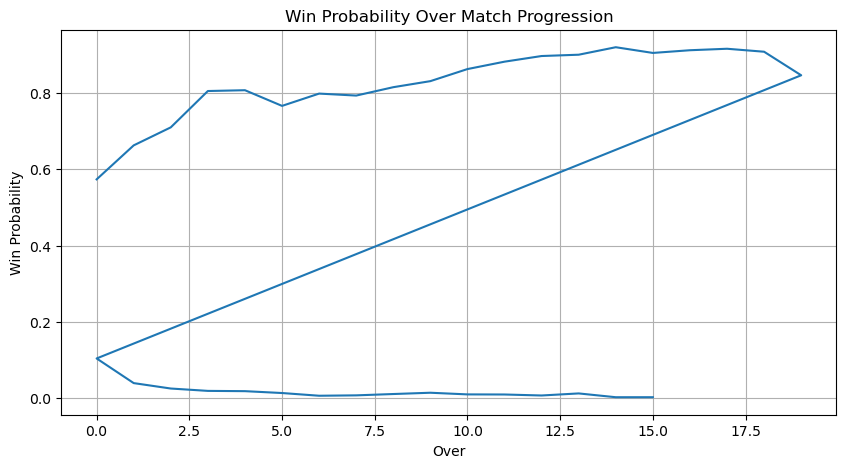

In [67]:
sample_match = over_df[over_df["match_id"] == over_df["match_id"].iloc[0]]

plt.figure(figsize=(10,5))
plt.plot(sample_match["over"], sample_match["win_probability"])
plt.xlabel("Over")
plt.ylabel("Win Probability")
plt.title("Win Probability Over Match Progression")
plt.grid(True)
plt.show()

In [71]:
over_df["prev_win_prob"] = over_df.groupby(
    ["match_id", "inning"]
)["win_probability"].shift(1)

over_df["impact"] = over_df["win_probability"] - over_df["prev_win_prob"]
over_df.fillna(0, inplace=True)

In [73]:
impact_df = df.merge(
    over_df[["match_id", "inning", "over", "impact"]],
    on=["match_id", "inning", "over"],
    how="left"
)

In [75]:
player_impact = (
    impact_df
    .groupby("batter")["impact"]
    .sum()
    .reset_index()
    .sort_values(by="impact", ascending=False)
)

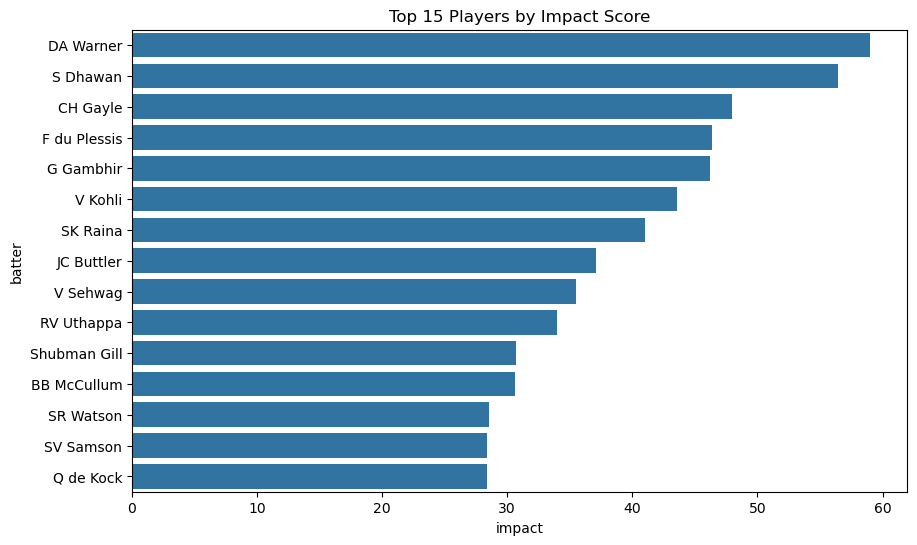

In [77]:
top_players = player_impact.head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=top_players, x="impact", y="batter")
plt.title("Top 15 Players by Impact Score")
plt.show()

In [79]:
over_df.to_csv("processed_match_state.csv", index=False)
player_impact.to_csv("player_impact_scores.csv", index=False)